In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gurobipy import *
import gurobipy as gp
from gurobipy import GRB
import os
sns.set(style ="whitegrid", font_scale=1.5)
from matplotlib.ticker import MultipleLocator
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
custom_colors = ["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap_colors = ["#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
color_palette = np.array(["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"])
matplotlib.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})
from tqdm import tqdm
import sys
import os
import pickle
import importlib
import re
from scipy.stats import norm
from scipy.linalg import sqrtm
import scipy.sparse as sp
from scipy.stats import skewnorm

### Data Processing

In [20]:
import importlib
import utils
importlib.reload(utils)
from utils import calc_cum_arrive, calc_cum_depart #, calc_wasted_capacity

In [21]:
df = pd.read_excel('BCN.xlsx').iloc[:260,:]
df['Time'] = pd.to_timedelta(df['Time'].astype(str))
df['minutes'] = df['Time'].dt.total_seconds() / 60
df['slots'] = df['minutes'] // 15
df = df[['Aircraft Capacity', 'slots']] 
latest_arrival = df['slots'].to_numpy()

In [58]:
c = np.zeros(shape=(df.shape[0], 96))
for i in range(df.shape[0]):
    mean_security_time = df['slots'].iloc[i] - 4
    for j in range(96):
        if j < mean_security_time:
            c[i,j] = (mean_security_time-j)**2
        elif j > mean_security_time:
            c[i,j] = j-mean_security_time

### Run Model

In [354]:
import model
importlib.reload(model)
from model import ROSecurity

In [355]:
inst = ROSecurity(df, n_slots=96, cost=c)
solution = inst.run(capacity=800, gamma=0.01, alpha=0.7, sigma=0.2)

  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:00<00:00, 18462.72it/s]


Set parameter NonConvex to value 2


### Visualization

In [356]:
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})

In [357]:
m = Model('Assignment')
x = m.addVars(c.shape[0], c.shape[1], vtype=GRB.CONTINUOUS, name='x')
for i in tqdm(range(c.shape[0])):
    m.addConstr(quicksum(x[i,j] for j in range(c.shape[1])) == 1)
for j in tqdm(range(c.shape[1])):
    m.addConstr(quicksum(x[i,j]*df['Aircraft Capacity'][i] for i in range(c.shape[0])) <= 800)
for idx, desired_arrival in enumerate(inst.latest_arrival_time):
    m.addConstr(quicksum(x[idx,j] for j in range(c.shape[1]) if (j < desired_arrival-16) | (j >= desired_arrival)) == 0)

m.setObjective(quicksum(x[i,j]*c[i,j]*df['Aircraft Capacity'][i] for i in range(c.shape[0]) for j in range(c.shape[1])), GRB.MINIMIZE)
m.update()
m.setParam('OutputFlag', 0)
m.optimize()
deterministic = np.zeros((c.shape[0], c.shape[1]))
for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        deterministic[i, j] = m.getVarByName(f'x[{i},{j}]').x

100%|██████████| 96/96 [00:00<00:00, 1689.09it/s]


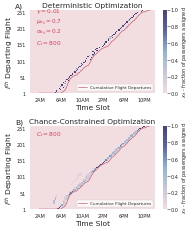

In [370]:
fig, ax = plt.subplots(2, 1, figsize=(6.75,8), dpi=30)
sns.heatmap(solution, cmap=cmap, ax=ax[1])
sns.heatmap(deterministic, cmap=cmap, ax=ax[0])

for i in range(2):
    ax[i].set(xlabel='Time Slot', ylabel=r'$i^{th}$ Departing Flight', 
        xticks = [i*16-8 for i in range(1,7)],
        xticklabels=['2AM', '6AM', '10AM', '2PM', '6PM', '10PM'],
        yticks = [i*50 for i in range(6)],
        yticklabels=[i for i in range(1, 301, 50)])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0, ha='center')
    ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=0, ha='right')
    ax[i].invert_yaxis()
    ax[i].plot(calc_cum_arrive(df['slots'].to_numpy()+1), color=color_palette[0], label='Cumulative Flight Departures')
    ax[i].legend(loc='lower right', fontsize=10 )

cbaro = ax[0].collections[0].colorbar
cbaro.ax.set_yticks([i*0.2 for i in range(6)])
cbaro.ax.set_ylabel(r"$x_{it}$ - fraction of passengers assigned", fontsize=12) 
cbar = ax[1].collections[0].colorbar
cbar.ax.set_ylabel(r"$x_{it}$ - fraction of passengers assigned", fontsize=12) 

ax[0].text(
    0.05, 0.80, 
    r'$\gamma = 0.01$' + '\n' + 
    r'$\mu_{\alpha_{it}}=0.7$' + '\n' +
    r'$\sigma_{\alpha_{it}}=0.2$' + '\n' + 
    r'$C_{t}=800$', 
    ha='left', va='center', 
    transform=ax[0].transAxes, 
    fontsize=14, 
    color='#ce4257'
)
ax[1].text(0.05, 0.90,  r'$C_{t}=800$',  ha='left', va='center', 
    transform=ax[1].transAxes, 
    fontsize=14, 
    color='#ce4257')
ax[0].set_title('Deterministic Optimization')
ax[1].set_title('Chance-Constrained Optimization')

ax[0].text(-0.12, 1.05, 'A)', ha='left', va='center', transform=ax[0].transAxes)
ax[1].text(-0.12, 1.05, 'B)', ha='left', va='center', transform=ax[1].transAxes)

plt.tight_layout()



### Queuing
 

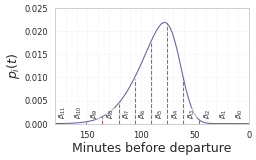

In [214]:
from scipy.stats import skewnorm
#pg292
mu = 64     # Mean
sigma = 30   # Standard deviation
alpha = 3    # Skewness

# Define the skew-normal distribution
x = np.linspace(0, 180, 72)  # Range for x values
pdf = skewnorm.pdf(x, alpha, loc=mu, scale=sigma)  # Probability density function
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=50)
ax.plot(x, pdf, color=color_palette[-2])
for t in range(12):
    ax.plot([t*15+1, t*15+1], [0, pdf[t*6]], color=color_palette[0], linestyle='--')
    ax.text(t*15+8, 0.001, fr"$\beta_{{{{i}}{t}}}$", ha='center', va='bottom', fontsize=10, rotation=90,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.05', alpha=0.5))
ax.set(xlim=(0, 180), ylim=(0, 0.025), 
       xlabel='Minutes before departure', ylabel=r'$p_{i}(t)$')

ax.invert_xaxis()
minorLocator = MultipleLocator(10)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(True, alpha=0.25, linestyle='--', which='both')

### Solution N-T Diagram

In [371]:
import utils
importlib.reload(utils)
from utils import calc_prob_den, generate_assigned_arrivals

In [372]:
arrival_time = np.array([])
for idx, row in df.iterrows():
    sampled_lead_time = skewnorm.rvs(alpha, loc=mu, scale=sigma, size=int(row['Aircraft Capacity'])) // 15
    arrival_time = np.concatenate([arrival_time, row['slots'] - sampled_lead_time])
    arrival_time[arrival_time < 0] = 0
departing_time = np.array([])
for idx, row in df.iterrows():
    departing_time_i = np.repeat(row['slots'], int(row['Aircraft Capacity']))
    departing_time = np.concatenate([departing_time, departing_time_i])

In [373]:
realized = calc_prob_den(solution, inst)
reassigned_arrival = generate_assigned_arrivals(realized, df)
deterministic_realized = calc_prob_den(deterministic, inst)
deterministic_reassigned_arrival = generate_assigned_arrivals(deterministic_realized, df)

In [374]:
cum_arr = calc_cum_arrive(arrival_time)
cum_dep = calc_cum_depart(arrival_time, 800)

assigned_arrival = calc_cum_arrive(reassigned_arrival)
assigned_depature = calc_cum_depart(reassigned_arrival, 800)

deterministic_arrival = calc_cum_arrive(deterministic_reassigned_arrival)
deterministic_depature = calc_cum_depart(deterministic_reassigned_arrival, 800)

flight_dep = calc_cum_arrive(departing_time)

Text(0.06, 0.5, 'Number of Passengers')

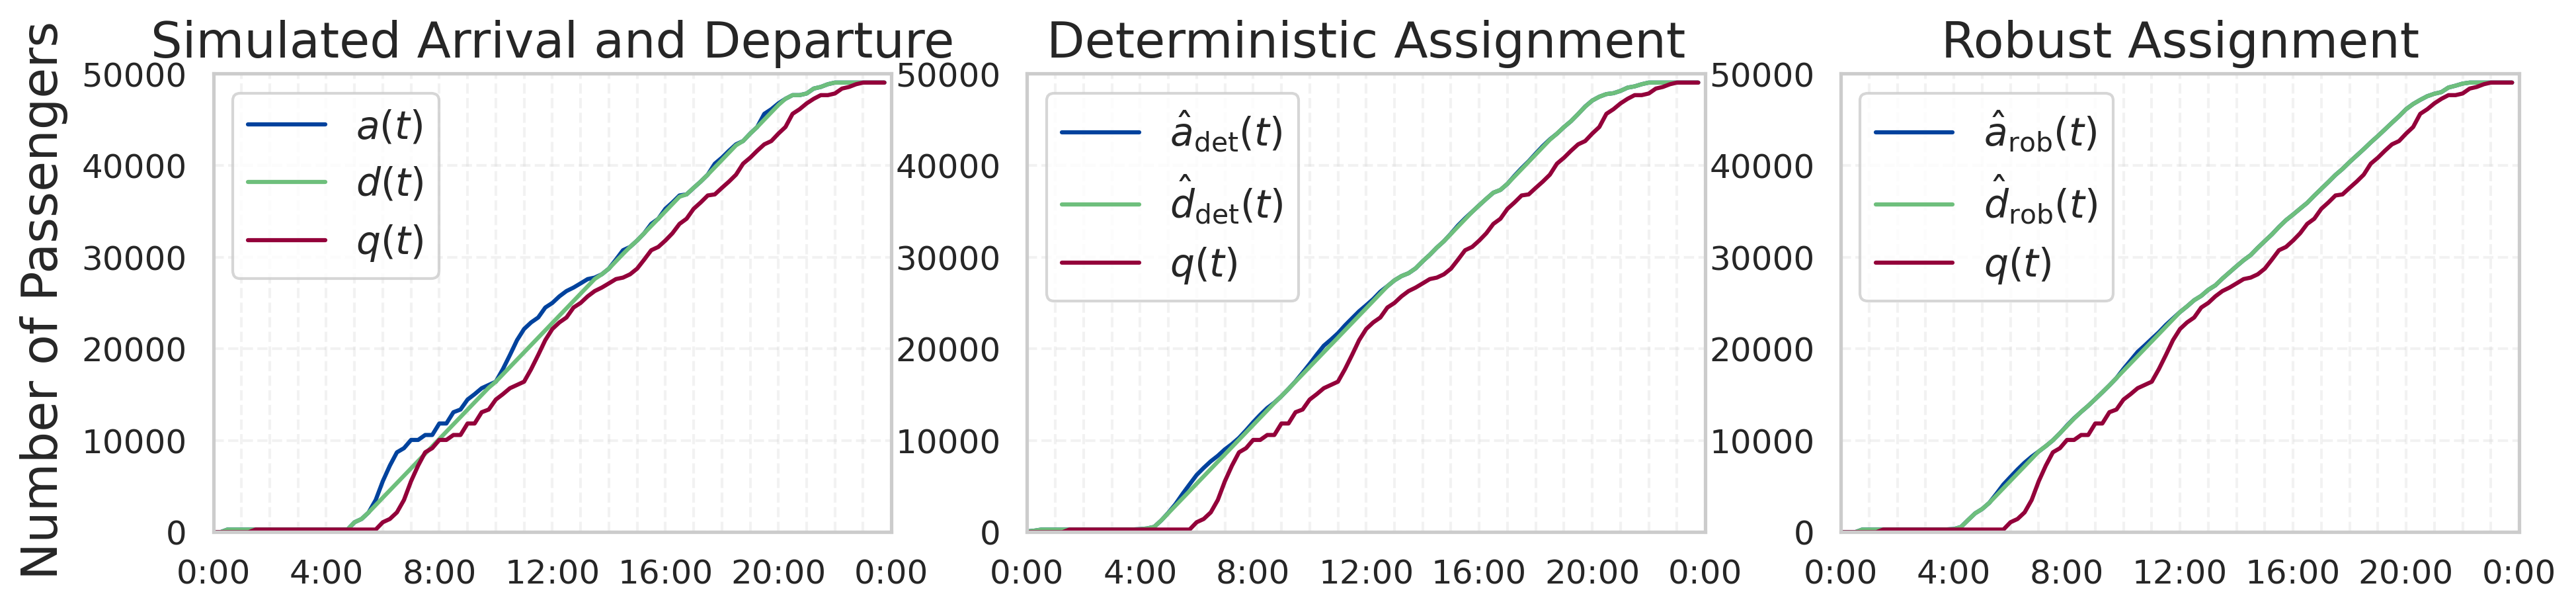

In [375]:
color_s = ['#93003a', '#00429d', '#93c4d2', '#6ebf7c']

fig, ax = plt.subplots(1, 3, figsize=(15, 3), dpi=300)

ax[0].plot(cum_arr, color = color_s[1], label=r'$a(t)$')
ax[0].plot(cum_dep, color = color_s[3], label=r'$d(t)$')
ax[0].plot(flight_dep, color = color_s[0], label=r'$q(t)$')

ax[1].plot(deterministic_arrival, color = color_s[1], label=r'$\hat{a}_{\text{det}}(t)$')
ax[1].plot(deterministic_depature, color = color_s[3], label=r'$\hat{d}_{\text{det}}(t)$')
ax[1].plot(flight_dep, color = color_s[0], label=r'$q(t)$')

ax[2].plot(assigned_arrival, color = color_s[1], label=r'$\hat{a}_{\text{rob}}(t)$')
ax[2].plot(assigned_depature, color = color_s[3], label=r'$\hat{d}_{\text{rob}}(t)$')
ax[2].plot(flight_dep, color = color_s[0], label=r'$q(t)$')

for i in range(3):
    ax[i].set(xticks = [i*16 for i in range(6)]+[96], xticklabels=[f"{i*4}:00" for i in range(6)]+[f"{0}:00"], 
              xlim=(0, 96), ylim=(0, 50000))
    ax[i].legend()
    minorLocator = MultipleLocator(4)
    ax[i].xaxis.set_minor_locator(minorLocator)
    ax[i].grid(True, alpha=0.25, linestyle='--', which='both')

ax[0].set(title='Simulated Arrival and Departure')
ax[1].set(title='Deterministic Assignment')
ax[2].set(title='Chance-Constrained Assignment')

fig.text(0.06, 0.5, 'Number of Passengers', va='center', rotation='vertical')


In [296]:
robust_waiting_time = np.sum((assigned_arrival-assigned_depature)*15) / 60
deterministic_waiting_time = np.sum((deterministic_arrival-deterministic_depature)*15) / 60
regular_waiting_time = np.sum((cum_arr-cum_dep)*15) / 60

In [299]:
regular_waiting_time - deterministic_waiting_time, regular_waiting_time - robust_waiting_time

(6009.25, 8161.0)

In [304]:
8161.0 / regular_waiting_time

0.8848770702881461

In [203]:
det_cost = 0
robust_cost = 0
for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        det_cost += c[i,j]*deterministic[i,j]*df['Aircraft Capacity'][i]
        robust_cost += c[i,j]*solution[i,j]*df['Aircraft Capacity'][i]


In [204]:
det_cost

32126.0

In [327]:
TTS = []
all_solution = []

for gamma in [0.01, 0.05, 0.1]:
    inst = ROSecurity(df, n_slots=96, cost=c)
    solution = inst.run(capacity=800, gamma=gamma, alpha=0.7, sigma=0.2)
    realized = calc_prob_den(solution, inst)
    reassigned_arrival = generate_assigned_arrivals(realized, df)
    assigned_arrival = calc_cum_arrive(reassigned_arrival)
    assigned_depature = calc_cum_depart(reassigned_arrival, 800)
    robust_waiting_time = np.sum((assigned_arrival-assigned_depature)*15) / 60
    TTS.append(robust_waiting_time)
    all_solution.append(solution)


for alpha in [0.7, 0.9, 0.99]:
    inst = ROSecurity(df, n_slots=96, cost=c)
    solution = inst.run(capacity=800, gamma=0.01, alpha=alpha, sigma=0.2)
    realized = calc_prob_den(solution, inst)
    reassigned_arrival = generate_assigned_arrivals(realized, df)
    assigned_arrival = calc_cum_arrive(reassigned_arrival)
    assigned_depature = calc_cum_depart(reassigned_arrival, 800)
    robust_waiting_time = np.sum((assigned_arrival-assigned_depature)*15) / 60
    TTS.append(robust_waiting_time)
    all_solution.append(solution)
        

for sigma in [0.05, 0.1, 0.2]:
    inst = ROSecurity(df, n_slots=96, cost=c)
    solution = inst.run(capacity=800, gamma=0.01, alpha=0.7, sigma=sigma)
    realized = calc_prob_den(solution, inst)
    reassigned_arrival = generate_assigned_arrivals(realized, df)
    assigned_arrival = calc_cum_arrive(reassigned_arrival)
    assigned_depature = calc_cum_depart(reassigned_arrival, 800)
    robust_waiting_time = np.sum((assigned_arrival-assigned_depature)*15) / 60
    TTS.append(robust_waiting_time)
    all_solution.append(solution)

  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:00<00:00, 27672.53it/s]

Set parameter NonConvex to value 2



  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:00<00:00, 33104.21it/s]

Set parameter NonConvex to value 2



  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:00<00:00, 39041.92it/s]

Set parameter NonConvex to value 2



  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:00<00:00, 36321.58it/s]

Set parameter NonConvex to value 2



  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:00<00:00, 28660.16it/s]

Set parameter NonConvex to value 2



  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:00<00:00, 34657.06it/s]

Set parameter NonConvex to value 2



  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:00<00:00, 39240.01it/s]

Set parameter NonConvex to value 2



  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:00<00:00, 34712.22it/s]

Set parameter NonConvex to value 2



  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 260/260 [00:00<00:00, 35833.44it/s]

Set parameter NonConvex to value 2


In [344]:
labels = []
for gamma in [0.01, 0.05, 0.1]:
    labels.append([gamma, 0.7, 0.2])
for alpha in [0.7, 0.9, 0.99]:
    labels.append([0.01, alpha, 0.2])
for sigma in [0.05, 0.1, 0.2]:
    labels.append([0.01, 0.7, sigma])

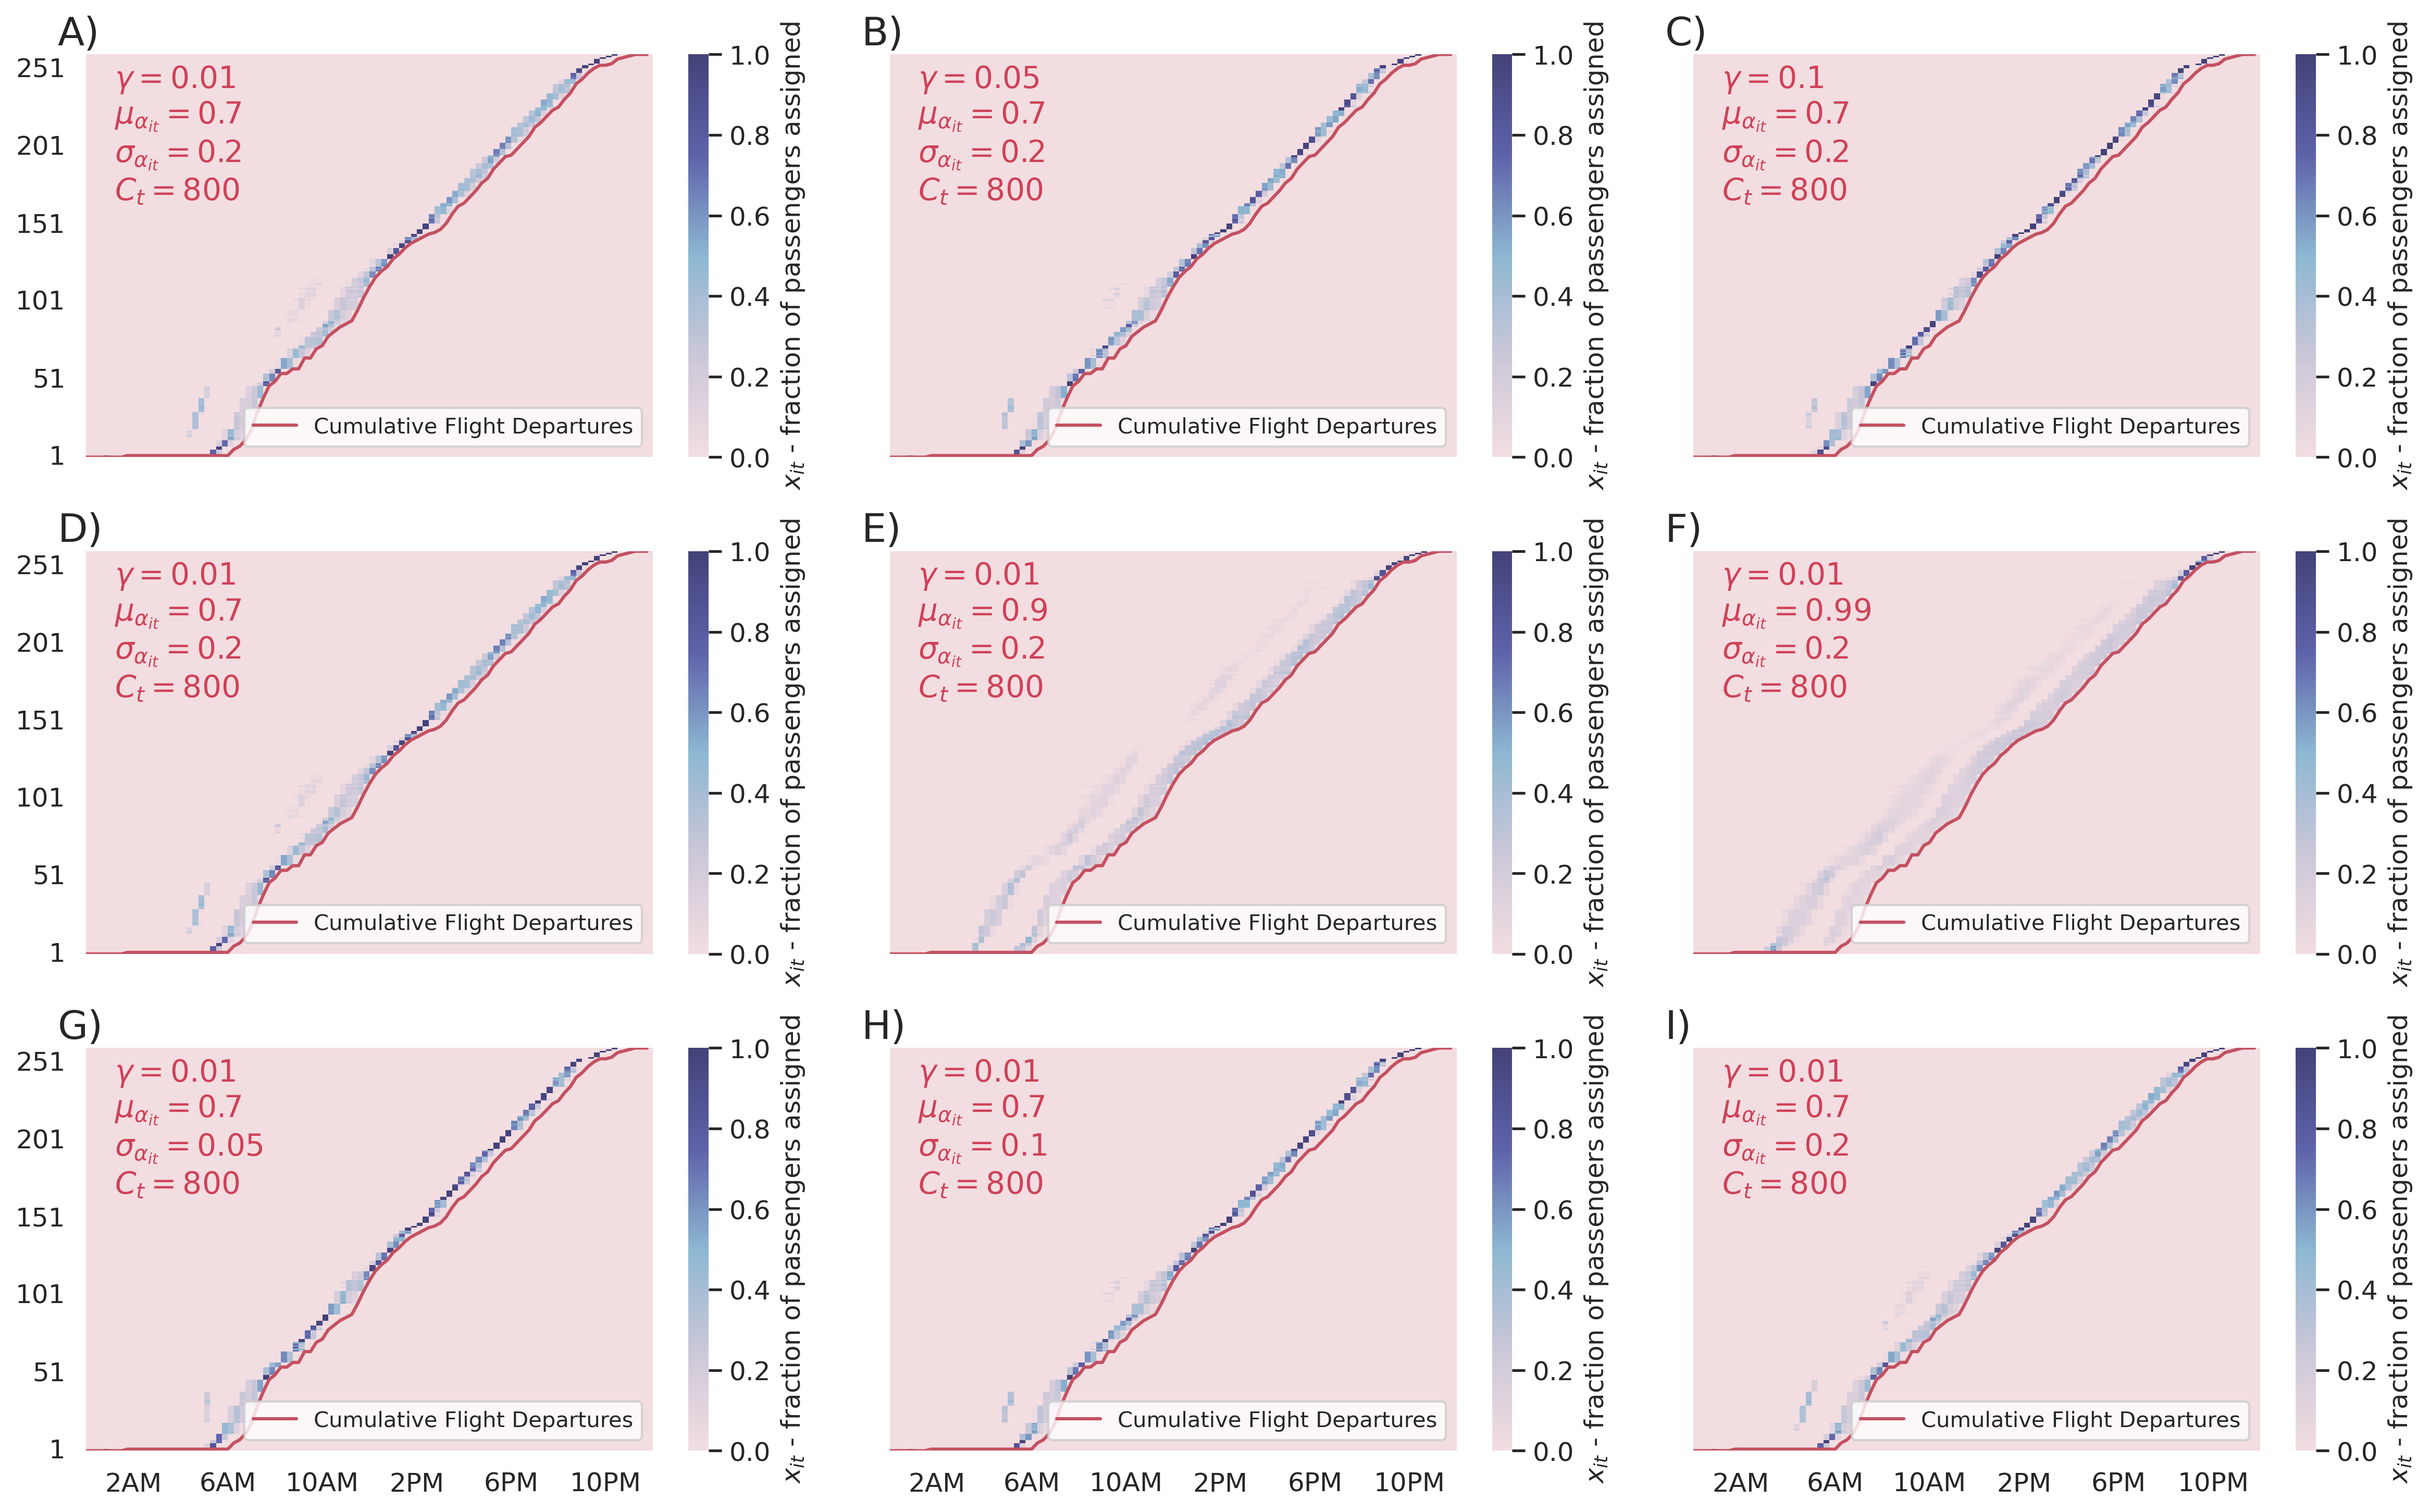

In [353]:

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
fig, ax = plt.subplots(3, 3, figsize=(16,10), dpi=300)

idx = -1
for i in range(3):
    for j in range(3):
        idx += 1
        sns.heatmap(all_solution[idx], cmap=cmap, ax=ax[i,j])
        ax[i,j].set(xlabel='', ylabel=r'', 
                    xticks = [i*16-8 for i in range(1,7)],
                    xticklabels=['2AM', '6AM', '10AM', '2PM', '6PM', '10PM'],
                    yticks = [i*50 for i in range(6)],
                    yticklabels=[i for i in range(1, 301, 50)])
        ax[i,j].set_xticklabels(ax[i,j].get_xticklabels(), rotation=0, ha='center')
        ax[i,j].set_yticklabels(ax[i,j].get_yticklabels(), rotation=0, ha='right')
        ax[i,j].invert_yaxis()
        ax[i,j].plot(calc_cum_arrive(df['slots'].to_numpy()+1), color=color_palette[0], label='Cumulative Flight Departures')
        ax[i,j].legend(loc='lower right', fontsize=10 )

        if j != 0:
            ax[i,j].set(ylabel='', yticks=[])
        if i != 2:
            ax[i,j].set(xlabel='', xticks=[])

        ax[i,j].text(
            0.05, 0.80, 
            rf'$\gamma = {labels[idx][0]}$' + '\n' + 
            rf'$\mu_{{\alpha_{{it}}}}={labels[idx][1]}$' + '\n' +
            rf'$\sigma_{{\alpha_{{it}}}}={labels[idx][2]}$' + '\n' + 
            r'$C_{t}=800$', 
            ha='left', va='center', 
            transform=ax[i,j].transAxes, 
            fontsize=14, 
            color='#ce4257'
        )
        ax[i,j].text(-0.05, 1.05, f'{letters[idx]})', ha='left', va='center', transform=ax[i,j].transAxes)

        cbaro = ax[i,j].collections[0].colorbar
        cbaro.ax.set_yticks([i*0.2 for i in range(6)])
        cbaro.ax.set_ylabel(r"$x_{it}$ - fraction of passengers assigned", fontsize=12) 


plt.tight_layout()



In [316]:
all_solution

{(0.01,
  0.5,
  0.1): array([[4.88640058e-12, 7.31573732e-12, 1.65571266e-11, ...,
         1.14148382e-13, 1.14189850e-13, 1.14231093e-13],
        [1.33123496e-13, 1.30487738e-13, 1.20614555e-13, ...,
         1.09806733e-13, 1.09837992e-13, 1.09869127e-13],
        [1.26984355e-13, 1.25127440e-13, 1.18052618e-13, ...,
         1.08566005e-13, 1.08593620e-13, 1.08621141e-13],
        ...,
        [1.14134167e-13, 1.14301609e-13, 1.14361612e-13, ...,
         7.66350301e-14, 7.67024928e-14, 7.67697854e-14],
        [1.14748747e-13, 1.14993950e-13, 1.15169818e-13, ...,
         6.47507216e-14, 6.48864116e-14, 6.50216037e-14],
        [1.14083768e-13, 1.14234865e-13, 1.14286535e-13, ...,
         7.36285971e-14, 7.37003368e-14, 7.37718979e-14]]),
 (0.05,
  0.5,
  0.1): array([[1.25994051e-12, 1.72693162e-12, 7.51637101e-12, ...,
         9.99406548e-14, 9.98282843e-14, 9.97161533e-14],
        [8.26502829e-14, 8.46782665e-14, 8.69593233e-14, ...,
         1.06753576e-13, 1.06657886e-13